library 설치 및 경로 설정

In [17]:
import sys
import os
# 프로젝트 폴더명 입력
sys.path.insert(0, os.getcwd()+'/drive/My Drive/Colab Notebooks/recommend_music_by_sentiment_analysis')
import config


['/content/drive/My Drive/Colab Notebooks/recommend_music_by_sentiment_analysis', '/content/recommend_music_by_sentiment_analysis', '/content/recommend_music_by_sentiment', '/content', '/content', '/content', '/content', '', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']
/content/drive/My Drive/Colab Notebooks/recommend_music_by_sentiment_analysis/dataset/


In [18]:
!pip install konlpy

# dataset 경로
DATASET_PATH = config.PATH_CONFIG['DATASET_PATH']
# 불용어 파일 이름
STOP_WORDS_FILE = config.PATH_CONFIG['STOP_WORDS_FILE']
# 학습 데이터 파일 이름
TRAIN_DATA_FILE = config.PATH_CONFIG['TRAIN_DATA_FILE']
# 테스트 데이터 파일 이름
TEST_DATA_FILE = config.PATH_CONFIG['TEST_DATA_FILE']

     |████████████████████████████████| 19.4MB 22.9MB/s 
     |████████████████████████████████| 3.8MB 53.5MB/s 
     |████████████████████████████████| 92kB 12.1MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


stop word 사전 생성

In [19]:
f = open(DATASET_PATH + STOP_WORDS_FILE,'r')
stop_words = []
while True:
    line = f.readline()
    if not line: break
    stop_words.append(line[:-1])

감정 class별로 빈도 수가 높은 단어 추출

In [20]:
from konlpy.tag import Kkma
from re import match
from collections import Counter
import pandas as pd

# ----------------------- 변수 ----------------------------------------------------------
EXCEL_NAME = 'sad.xlsx'
# 단어를 몇 개까지 추출할 지
TOP_NUMBER = 10
# ----------------------------------------------------------------------------------------

kkma = Kkma()
xlsx = pd.read_excel(DATASET_PATH + EXCEL_NAME, names = ['sentence', 'label'])
docs = ""
for i in xlsx['sentence']:
  docs+=i+'.'
ex_sent = kkma.sentences(docs)
nouns = []
for sent in ex_sent:
  for noun in kkma.nouns(sent):
    if len(str(noun)) >= 2 and not(match('^[0-9]', noun)) and (noun not in stop_words):
      nouns.append(noun)

word_count = {}
for noun in nouns:
  word_count[noun] = word_count.get(noun, 0) + 1


counter = Counter(word_count)
top_words = counter.most_common(TOP_NUMBER)
top_words

[('눈물', 230),
 ('친구', 194),
 ('상해', 168),
 ('주세', 79),
 ('남자', 68),
 ('엄마', 67),
 ('가슴', 52),
 ('감동적', 52),
 ('남자친구', 50),
 ('마음', 49)]

train_set, test_set의 data 분석

In [21]:
# 데이터 로드
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

train_data = pd.read_excel(DATASET_PATH + TRAIN_DATA_FILE)
test_data = pd.read_excel(DATASET_PATH + TEST_DATA_FILE)

train data의 class별 분포

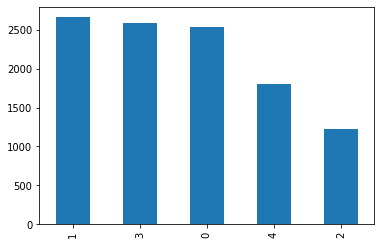

In [22]:
train_data['label'].value_counts().plot(kind = 'bar')

test data의 class별 분포

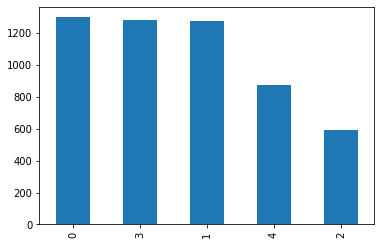

In [23]:
test_data['label'].value_counts().plot(kind = 'bar')

train과 test data의 class당 data 개수

In [24]:
print(train_data.groupby('label').size().reset_index(name = 'count'))
print(test_data.groupby('label').size().reset_index(name = 'count'))


   label  count
0      0   2537
1      1   2657
2      2   1224
3      3   2585
4      4   1798
   label  count
0      0   1298
1      1   1277
2      2    591
3      3   1280
4      4    875


data tokenizing

In [25]:

import konlpy
from konlpy.tag import Okt

okt = Okt()
x_train = []
for sentence in train_data['sentence']:
  temp_x = []
  temp_x = okt.morphs(sentence, stem = True)
  temp_x = [word for word in temp_x if not word in stop_words]
  x_train.append(temp_x)

x_test = []
for sentence in test_data['sentence']:
  tmp = []
  tmp = okt.morphs(sentence, stem = True)
  tmp = [word for word in tmp if not word in stop_words]
  x_test.append(tmp)
from keras.preprocessing.text import Tokenizer

max_words = 35000
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

train data 문장들의 길이 분석

제목의 최대 길이 : 16
제목의 평균 길이 : 4.881955374502361


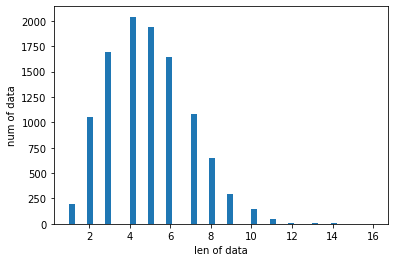

In [26]:
print("제목의 최대 길이 :",max(len(l) for l in x_train))
print("제목의 평균 길이 :", sum(map(len, x_train)) / len(x_train))
plt.hist([len(s) for s in x_train], bins = 50)
plt.xlabel('len of data')
plt.ylabel('num of data')
plt.show()

test data 문장들의 길이 분석

제목의 최대 길이 : 14
제목의 평균 길이 : 4.565119338470212


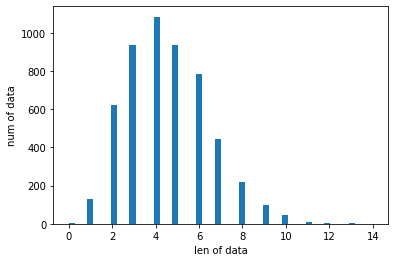

In [27]:
print("제목의 최대 길이 :",max(len(l) for l in x_test))
print("제목의 평균 길이 :", sum(map(len, x_test)) / len(x_test))
plt.hist([len(s) for s in x_test], bins = 50)
plt.xlabel('len of data')
plt.ylabel('num of data')
plt.show()